In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: wheeler

include("../lib/gif.jl")

plot_animation (generic function with 1 method)

In [2]:
using Distributions

plt.gr()
plt.default(label=false, colorbar=false)

f, ∇f = wheeler(1.5)
xdomain = LinRange(0, 3.5, 400)
ydomain = LinRange(0, 3.5, 400)

plotsize = (600, 600)

function plot_mv_normal!(plot, mv_normal)
    function order_points_for_path(points)
        ordered_points = sort(points, by=x->x[1])
        last_upper, last_lower = ordered_points[1], ordered_points[1]
        upper_path, lower_path = [], [last_lower]
        for point in ordered_points
            if abs(point[2] - last_upper[2]) <= abs(point[2] - last_lower[2])
                push!(upper_path, point)
                last_upper = point
            else
                pushfirst!(lower_path, point)
                last_lower = point
            end
        end
        return [upper_path; lower_path]
    end
    points = rand(mv_normal, Int(2e5))
    points = [(point[1], point[2], logpdf(mv_normal, point)) for point in eachcol(points)] 
    points = sort(points, by=x->x[3])
    level_idxs = floor.(Int32, [0.25, 0.5, 0.75, 0.9] * length(points)) 
    for (i, start_idx) in enumerate(level_idxs)
        end_idx = min(start_idx + 75 * (length(level_idxs) + 1 - i), length(points))
        level_points = points[start_idx:end_idx]
        path = order_points_for_path(level_points)
        plt.plot!(plot, [pt[1] for pt in path], [pt[2] for pt in path]; color=:white)
    end
    plt.scatter!(plot, [mv_normal.μ[1]], [mv_normal.μ[2]]; markershape=:circle, markersize=2, markerstrokewidth=0, markercolor=:red)
end

function plot_heatmap_and_contours((mv_normal, samples); size=plotsize)
    plot = plt.heatmap(xdomain, ydomain, (x, y) -> f([x, y]); color=plt.cgrad(:dense), xaxis=false, yaxis=false, size=size)
    plot_mv_normal!(plot, mv_normal)
    sample_size = Base.size(samples)[1]
    if sample_size > 0
        plt.scatter!(plot, samples[1,:], samples[2,:]; markershape=:circle, markersize=2, markerstrokewidth=0)
    end
    return plot
end

# mv_normal = MvNormal([2.0, 1.5], [1e-2 1e-2; 1e-2 2e-2])
# plt.plot(plot_heatmap_and_contours((mv_normal, [])); size=plotsize)

plot_heatmap_and_contours (generic function with 1 method)

"Optimum: x=[1.1023, 1.4109]"

  0.194759 seconds (240.29 k allocations: 12.785 MiB, 97.75% compilation time)


┌ Info: Saved animation to 
│   fn = /tmp/jl_S5AruZOZCD.gif
└ @ Plots /home/nguymin4/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_S5AruZOZCD.gif")
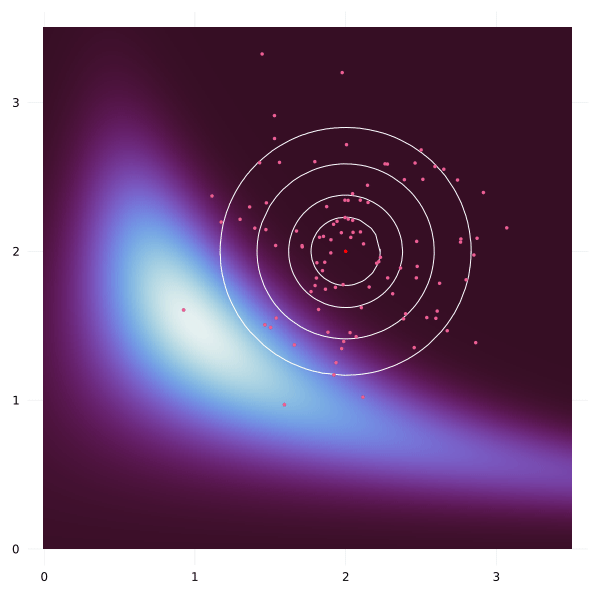

In [7]:
import Random

Random.seed!(0)

function natural_evolution_strategies(f, θ; α=1e-2, sample_size=1e2, max_iter = 100)
    history = []
    μ, A = θ 

    for iter in 1:max_iter
        Σ = A'*A
        mv_normal = MvNormal(μ, Σ)
        samples = rand(mv_normal, Int(sample_size))
        sample_values = mapslices(f, samples, dims=1)
        push!(history, (deepcopy(mv_normal), samples))

        Σ_inv = inv(Σ + Matrix(1.0I, 2, 2) / 5)
        μ_grad = Σ_inv * (samples .- μ)
        μ .-= α * sum(sample_values .* μ_grad, dims=2) / sample_size
 
        Σ_grads = [(Σ_inv * (x - μ) * (x -μ)' * Σ_inv - Σ_inv) / 2 for x in eachcol(samples)]
        A .-= α * A * sum(map((v, Σ_grad) -> v * (Σ_grad + Σ_grad'), sample_values, Σ_grads)) / sample_size
    end
    return μ, history
end

x, history = @time natural_evolution_strategies(f, ([2.0, 2.0], Matrix(0.5I, 2, 2)); α=0.75, sample_size=100, max_iter=20)
display("Optimum: x=$(round.(x, digits=4))")
plot_animation(plot_heatmap_and_contours, history)